In [1]:
%matplotlib inline

/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


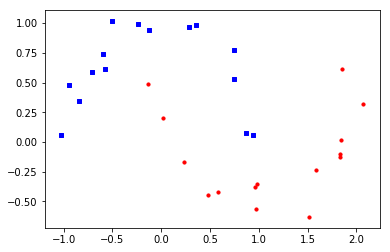

saving model epoch 1
saved model epoch 1


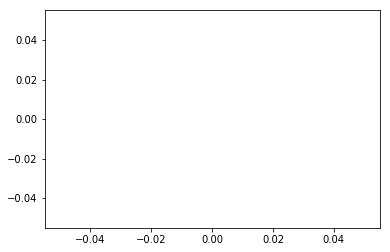

saving model epoch 2


saved model epoch 2


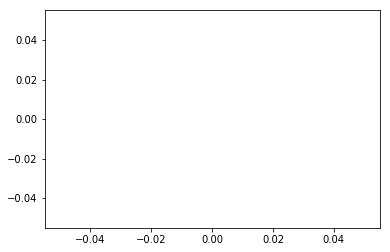

saving model epoch 3


saved model epoch 3


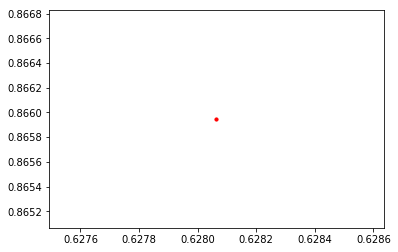

saving model epoch 4
saved model epoch 4


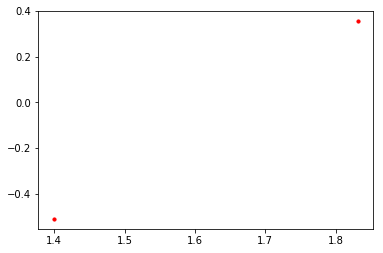

In [2]:
#!/usr/bin/env python3.6
# http://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-pyc
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

PLOT = True

n_samples = 40
train_samples = 30
tets_samples = n_samples - train_samples

coords, labels = make_moons(n_samples=n_samples, random_state=0, noise=0.1)
train_in = coords[:train_samples]
train_out = labels[:train_samples]
test_in = coords[train_samples:]
test_out = labels[train_samples:]

x = train_in[:, 0]
y = train_in[:, 1]

x_t = test_in[:, 0]
y_t = test_in[:, 1]

if PLOT:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(x[train_out == 0], y[train_out == 0], s=10, c='b', marker="s", label='first')
    ax1.scatter(x[train_out == 1], y[train_out == 1], s=10, c='r', marker="o", label='second')
    # plt.legend(loc='upper left');
    plt.show()

train_out = np.expand_dims(train_out, axis=1)
test_out = np.expand_dims(test_out, axis=1)

learning_rate = 10
training_epochs = 4
batch_size = 1
display_step = 1

# Network Parameters
n_hidden = 2
n_input = 2
n_classes = 1


checkpoint_dir = "checkpoints"
log_dir = "logdir"

CPU = True
if CPU:
    config = tf.ConfigProto(device_count = {'GPU': 0})
else:
    config = None

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


class Graph():
    def __init__(self, config=None, daily=False, batch_sz=32, train_epochs=training_epochs):
        # calc total batch count
        self.sess = tf.Session(config=config)

        self.x = tf.placeholder(tf.float32, shape=(None, n_input))
        self.y = tf.placeholder(tf.int32, shape=(None, n_classes))

        layer_1 = tf.layers.dense(self.x, n_hidden) # TODO 
        self.out = tf.layers.dense(layer_1, n_classes)   # TODO  remove

        self.classes = tf.cast(tf.floor(self.out + 0.5), tf.int32)
        self.istarget = tf.to_float(tf.not_equal(self.y, 0))
        self.acc = tf.reduce_sum(tf.to_float(tf.equal(self.classes, self.y))*self.istarget) / (tf.reduce_sum(self.istarget))
        tf.summary.scalar('acc', self.acc)

        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        # loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.out, labels=self.y))
        self.loss_op = tf.reduce_mean(tf.losses.mean_squared_error(self.y, self.out))
        
        tf.summary.scalar('mean_loss', self.loss_op)

        if not daily:
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = optimizer.minimize(self.loss_op, global_step=self.global_step)
        
        self.merged = tf.summary.merge_all()
        self.saver = tf.train.Saver(max_to_keep=10)

        if not daily:
            self.sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
            self.train_writer = tf.summary.FileWriter(os.path.join(log_dir, 'train'))
            self.test_writer = tf.summary.FileWriter(os.path.join(log_dir, 'test'))

    def train(self, epoch):
        num_batch = len(train_in) // batch_size
        # import ipdb; ipdb.set_trace() # train_in, train_out
        # 9000x2, 9000
        inp_len = len(train_in)
        all_data = list(range(inp_len))
        random.shuffle(all_data)
        indicies = all_data[:num_batch*batch_size]

        for i in tqdm(range(num_batch), total=num_batch, ncols=70, leave=False, unit='b'):
            # get batch
            x = np.take(train_in , indicies[i*batch_size:(i+1)*batch_size], axis=0)
            y = np.take(train_out, indicies[i*batch_size:(i+1)*batch_size], axis=0)
            # run batch
            summary, _, self.gs = self.sess.run([self.merged, self.train_op, self.global_step], feed_dict={self.x: x, self.y: y})
            self.train_writer.add_summary(summary, self.gs)
           
        print("saving model epoch {}".format(epoch))
        self.saver.save(self.sess, os.path.join(checkpoint_dir, 'model_epoch_{}'.format(epoch)))
        print("saved model epoch {}".format(epoch))

    def test(self):
        summary, output = self.sess.run([self.merged, self.classes], feed_dict={self.x: test_in, self.y: test_out})
        self.test_writer.add_summary(summary, self.gs)
        output = np.squeeze(output)
        # import ipdb; ipdb.set_trace()
        if PLOT:
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
            ax1.scatter(x_t[output == 0], y_t[output == 0], s=10, c='b', marker="s", label='first')
            ax1.scatter(x_t[output == 1], y_t[output == 1], s=10, c='r', marker="o", label='second')
            # plt.legend(loc='upper left');
            plt.show()


g = Graph(config=config)
for epoch in range(1, training_epochs+1):
    g.train(epoch)
    g.test()           